## Tree Models
Run tree models in the order of bested selected variable to worse by adding one at a time and running repeated k-folds.

In [19]:
import numpy as np
import pandas as pd
from sklearn.model_selection import RepeatedKFold, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
train = pd.read_csv('../data/train.csv')
X_test = pd.read_csv('../data/test.csv')
y_train = train['Y']
train.head()

,Y,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15
0,12.083210,16,7,15.9,1,13.6,26,3.6,-20.0,6,2,378,6,7.85,1042.80,6
1,12.433754,19,14,16.4,3,16.7,19,3.5,32.9,0,3,595,11,0.86,83.55,5
2,11.659181,12,14,16.0,2,16.5,17,3.8,45.4,0,2,210,8,1.30,134.29,5
3,15.449989,21,2,16.3,4,9.6,23,3.4,29.0,26,4,1353,10,5.52,736.77,11
4,12.805393,11,11,15.3,2,11.9,22,3.5,35.0,1,3,790,8,1.63,407.42,4


In [14]:
best_vars = ['X1', 'X15', 'X12', 'X4', 'X6', 'X13', 'X8', 'X14', 'X2', 'X11', 'X5', 'X10', 'X7', 'X3', 'X9']
current_vars = []
results = {
    'Rf': [],
    'Gb': [],
    'Xtr': []
}

In [15]:
for var in best_vars:
    current_vars.append(var)
    X_train = train[current_vars]
    cv = RepeatedKFold(n_splits=5, n_repeats=20, random_state=1)
    
    model = RandomForestRegressor(max_depth=5, random_state=0)
    rf_scores = cross_val_score(model, X_train, y_train, scoring=make_scorer(mean_squared_error,greater_is_better=False), cv=cv, n_jobs=-1)
    rf_scores = np.abs(rf_scores)
    results['Rf'].append(np.median(rf_scores))
    
    model = GradientBoostingRegressor(random_state=0)
    gb_scores = cross_val_score(model, X_train, y_train, scoring=make_scorer(mean_squared_error,greater_is_better=False), cv=cv, n_jobs=-1)
    gb_scores = np.abs(gb_scores)
    results['Gb'].append(np.median(gb_scores))
    
    model = ExtraTreesRegressor(random_state=0)
    xtr_scores = cross_val_score(model, X_train, y_train, scoring=make_scorer(mean_squared_error,greater_is_better=False), cv=cv, n_jobs=-1)
    xtr_scores = np.abs(xtr_scores)
    results['Xtr'].append(np.median(xtr_scores))
    
print(results)

{'Rf': [1.955527269393012, 1.8283804798120316, 1.6626877658520163, 1.673489943183185, 1.7216246339473356, 1.7485926737120563, 1.7554253108428162, 1.7568999172538218, 1.7395086787557514, 1.7332242459868883, 1.7234648768019567, 1.699223947323774, 1.7085535497409006, 1.709995676277122, 1.7140273233931467], 'Gb': [1.9659877901622962, 1.8431634716791678, 1.575459566551649, 1.5623265670179385, 1.6160229153176815, 1.6612843514288829, 1.684342444708303, 1.702854236457743, 1.657118305626482, 1.6748309332863962, 1.6578974007664247, 1.6389844925553596, 1.6591258305867758, 1.6763044431106104, 1.6829090961427244], 'Xtr': [2.016241789227829, 2.0525103184265996, 2.0166554551448987, 1.9968392000649813, 1.8530216346766748, 1.7842584363032374, 1.7715912937292593, 1.7879154558341566, 1.7363167617036672, 1.7867831010990622, 1.8129274092719487, 1.77216670571782, 1.8099740406296272, 1.8141281936630147, 1.8334131564478642]}


In [17]:
results = pd.DataFrame.from_dict(results)
results.head(5)

,Rf,Gb,Xtr
0,1.955527,1.965988,2.016242
1,1.828380,1.843163,2.052510
2,1.662688,1.575460,2.016655
3,1.673490,1.562327,1.996839
4,1.721625,1.616023,1.853022


<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

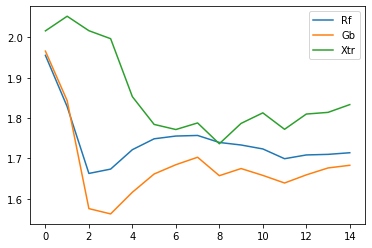

In [18]:
plt.figure()
results.plot()

## Model Tuning

### Random Forest

In [30]:
X_train = train[['X1','X15','X12','X4']]

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(5, 15, num=2)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


model = RandomForestRegressor()
model_tuned = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
model_tuned.fit(X_train, y_train)
model_tuned.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END learning_rate=0.01, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1800; total time=   2.9s
[CV] END learning_rate=0.01, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1800; total time=   2.8s
[CV] END learning_rate=0.01, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1800; total time=   2.7s
[CV] END learning_rate=0.01, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1800; total time=   1.2s
[CV] END learning_rate=0.001, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1200; total time=   1.3s
[CV] END learning_rate=0.001, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1200; total time=   1.3s
[CV] END learning_rate=0.001, max_depth=15, max_features=sqrt, min_samples_leaf=

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=800; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=800; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=800; total time=   2.0s
[CV] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1800; total time=   3.3s
[CV] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1800; total time=   3.5s
[CV] END bootstrap=False, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   1.1s
[CV] END bootstrap=False, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   1.0s
[CV] END bootstrap=False, max_depth=15

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1800; total time=   4.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1800; total time=   4.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1800; total time=   4.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1800; total time=   4.1s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1600; total time=   3.4s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1600; total time=   3.5s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1600; total time=   5.4s
[CV] END bootstrap=

[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=   4.5s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1800; total time=   4.1s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1800; total time=   4.2s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   0.9s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   0.9s
[CV] END bootstrap=False, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time=   3.5s
[CV] END bootstrap=False, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time=   3.6s
[CV] END bootstrap=False, max_depth=15, max_

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   1.0s
[CV] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1200; total time=   2.4s
[CV] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1200; total time=   2.3s
[CV] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1200; total time=   2.2s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   1.7s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   1.7s
[CV] END bootstrap=False, 

{'n_estimators': 1800,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': True}

In [31]:
print(model_tuned.best_params_)
model = model_tuned.best_estimator_
score = cross_val_score(model, X_train, y_train, scoring=make_scorer(mean_squared_error,greater_is_better=False), cv=cv, n_jobs=-1)
score = np.abs(score)
print(np.median(score))

{'n_estimators': 1800, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': None, 'bootstrap': True}
1.5996509970871269
[CV] END bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1200; total time=   2.9s
[CV] END bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1200; total time=   3.0s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   4.3s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   4.2s
[CV] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1600; total time=   3.0s
[CV] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1600; total time=   3.1s
[CV] END bootstr

In [28]:
X_train = train[['X1','X15','X12','X4']]

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(5, 15, num=2)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
learning_rate = [0.1, 0.01, 0.001]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'learning_rate': learning_rate}


model = GradientBoostingRegressor()
model_tuned = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
model_tuned.fit(X_train, y_train)
model_tuned.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END learning_rate=0.01, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time=   0.7s
[CV] END learning_rate=0.01, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time=   0.7s
[CV] END learning_rate=0.1, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1600; total time=   1.4s
[CV] END learning_rate=0.1, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1600; total time=   1.7s
[CV] END learning_rate=0.1, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1600; total time=   2.0s
[CV] END learning_rate=0.01, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=   2.1s
[CV] END learning_rate=0.01, max_depth=50, max_features=auto, min_samples_leaf=1, min_sample

[CV] END learning_rate=0.01, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1600; total time=   0.8s
[CV] END learning_rate=0.1, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; total time=   2.0s
[CV] END learning_rate=0.1, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; total time=   1.6s
[CV] END learning_rate=0.1, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; total time=   1.3s
[CV] END learning_rate=0.01, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   2.8s
[CV] END learning_rate=0.01, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   3.0s
[CV] END learning_r

[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=   0.6s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=   0.6s
[CV] END learning_rate=0.001, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1400; total time=   1.2s
[CV] END learning_rate=0.001, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1400; total time=   1.3s
[CV] END learning_rate=0.001, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.4s
[CV] END learning_rate=0.001, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.4s
[CV] END learning_rate=0.001, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.4s
[CV]

[CV] END learning_rate=0.1, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   0.9s
[CV] END learning_rate=0.01, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1600; total time=   1.8s
[CV] END learning_rate=0.01, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1600; total time=   1.8s
[CV] END learning_rate=0.01, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1600; total time=   1.8s
[CV] END learning_rate=0.001, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=2000; total time=   1.1s
[CV] END learning_rate=0.001, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=2000; total time=   1.1s
[CV] END learning_rate=0.001, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1600; total time=   2.4s
[CV

{'n_estimators': 600,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 5,
 'learning_rate': 0.01}

In [29]:
print(model_tuned.best_params_)
model = model_tuned.best_estimator_
score = cross_val_score(model, X_train, y_train, scoring=make_scorer(mean_squared_error,greater_is_better=False), cv=cv, n_jobs=-1)
score = np.abs(score)
print(np.median(score))

{'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 5, 'learning_rate': 0.01}
1.53993572783784
